# Построение модели прогнозирования температуры сплава.

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали. Модель должна показывать метрику качества MAE < 8.7.

**Описание этапа обработки сплава**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.

Решение задачи разделим на этапы:
1. Первичный анализ данных;
2. Подготовка данных к обучению модели;
3. Построение модели;
4. Тестирование модели;
5. Отчёт о проделанной работе.

In [1]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor

import shap

In [2]:
# Константы
SEED = 9082022

## Первичный анализ данных

Произведём загрузку данных. Для удобства работы с данными о дате и времени, на этапе загрузки осуществим преобразование колонок содержащих такие данные к типу `datetime`.

In [3]:
# Формируем список колонок сыпучих и проволочных добавок
bulks = ['Bulk '+ str(i) for i in range(1,16)]
wires = ['Wire '+ str(i) for i in range(1,10)]

# Загрузка данных
try:
    df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv', parse_dates=['Начало нагрева дугой','Конец нагрева дугой'])
    df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv', parse_dates = ['Время замера'])
    df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv', parse_dates=bulks)
    df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv', parse_dates=wires)
except:
    df_arc = pd.read_csv('d:/indastry_progect/final_steel/data_arc.csv', parse_dates=['Начало нагрева дугой','Конец нагрева дугой'])
    df_temp = pd.read_csv('d:/indastry_progect/final_steel/data_temp.csv', parse_dates = ['Время замера'])
    df_gas = pd.read_csv('d:/indastry_progect/final_steel/data_gas.csv')
    df_bulk = pd.read_csv('d:/indastry_progect/final_steel/data_bulk.csv')
    df_bulk_time = pd.read_csv('d:/indastry_progect/final_steel/data_bulk_time.csv', parse_dates=bulks)
    df_wire = pd.read_csv('d:/indastry_progect/final_steel/data_wire.csv')
    df_wire_time = pd.read_csv('d:/indastry_progect/final_steel/data_wire_time.csv', parse_dates=wires)

In [4]:
def data_info(df):
    """Изучение датасета"""
    display(df.head())
    display(df.info())
    display(df.describe())
    print('Количество дубликатов =', df.duplicated().sum())
    print('Количество уникальных партий =', len(df['key'].unique()))
    # Построение корреляционной матрицы
    size = len(df.columns)
    plt.figure(figsize=(size,size/2))
    df = df.drop('key', axis=1)
    try:
        corr_matrix = sns.heatmap(df.corr(),annot=True)
        corr_matrix.axes.set_title("Корреляционная матрица", fontsize=16)
        plt.show()
    
        sns.pairplot(df)
    except:
        print()

### Анализ данных о нагреве сплава электродами

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Количество дубликатов = 0
Количество уникальных партий = 3214


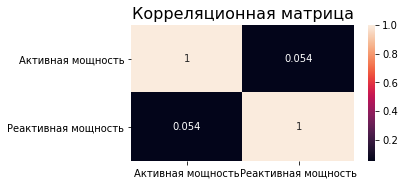

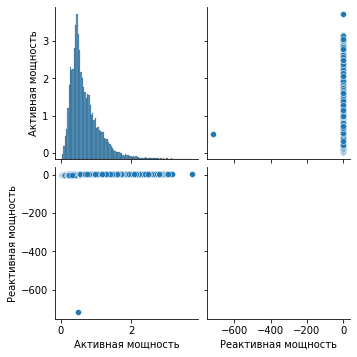

In [5]:
# Первый взгляд на данные
data_info(df_arc)

1. Сильных корреляционных зависимостей пока не наблюдается.
2. Значение реактивной мощьности = -715.504924 вызывает вопросы. Необходимо задать вопрос тем, кто разбирается в технологическом процессе корректно-ли данное значение. А пока, проанализируем данные без этого потенциального выброса.
3. Для более корректного анализа, сформируем следующие признаки:
    - Из данных о времени начала и конца нагрева сформируем признак `Время нагрева`.
    - Из активной и реактивной мощьности рассчитаем признак `Полная мощность`.
    - Из значений полной мощьности и времени нагрева рассчитаем признак `Энергия нагрева`.

In [6]:
# Формирование признаков
df_arc['Время нагрева'] = (df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']).astype('int64') / 1000000000
df_arc['Полная мощность'] = np.sqrt(df_arc['Активная мощность']**2 + df_arc['Реактивная мощность']**2)
df_arc['Энергия нагрева'] = df_arc['Полная мощность'] * df_arc['Время нагрева']

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева,Полная мощность,Энергия нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0,1.193639,272.149755
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0,0.959010,177.416785
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0,0.896038,154.118502
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0,1.970470,719.221394
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0,0.807239,119.471318


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14875 non-null  int64         
 1   Начало нагрева дугой  14875 non-null  datetime64[ns]
 2   Конец нагрева дугой   14875 non-null  datetime64[ns]
 3   Активная мощность     14875 non-null  float64       
 4   Реактивная мощность   14875 non-null  float64       
 5   Время нагрева         14875 non-null  float64       
 6   Полная мощность       14875 non-null  float64       
 7   Энергия нагрева       14875 non-null  float64       
dtypes: datetime64[ns](2), float64(5), int64(1)
memory usage: 1.0 MB


None

,key,Активная мощность,Реактивная мощность,Время нагрева,Полная мощность,Энергия нагрева
count,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.670453,0.500723,171.675160,0.838768,193.113136
std,934.593897,0.408170,0.310880,98.188759,0.509853,258.376798
min,1.000000,0.030002,0.020806,11.000000,0.036664,0.403301
25%,806.000000,0.395295,0.291003,107.000000,0.495322,53.509150
50%,1617.000000,0.555565,0.415984,147.000000,0.694926,101.447556
75%,2429.000000,0.857049,0.637403,214.000000,1.066748,227.434003
max,3241.000000,3.731596,2.676388,907.000000,4.592152,4165.081851


Количество дубликатов = 0
Количество уникальных партий = 3214


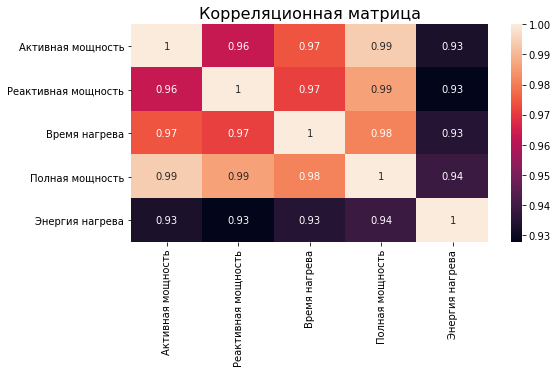

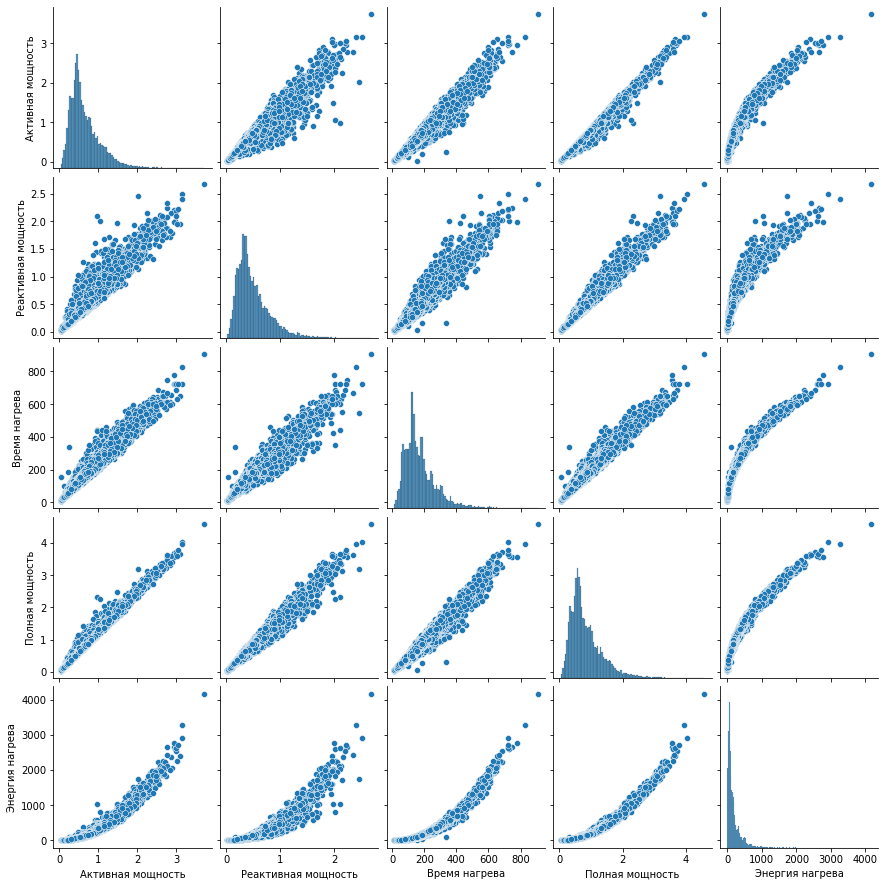

In [7]:
# Анализ преобразованных данных
data_info(df_arc[df_arc['Реактивная мощность'] > -700])

In [8]:
# Количество циклов нагрева одной партии
df_arc['key'].value_counts().sort_values()

530      1
2738     1
943      1
1169     1
49       1
        ..
46      13
2567    14
1513    15
1689    15
2108    16
Name: key, Length: 3214, dtype: int64

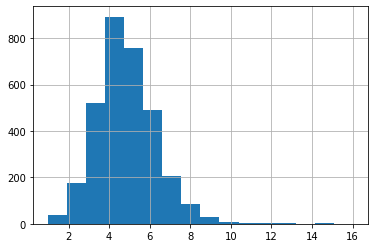

In [9]:
# Количество циклов нагрева одной партии
df_arc['key'].value_counts().sort_values().hist(bins=16);

**Вывод**
1. Пропусков и дубликатов нет.
2. Рассчитали и создали признаки:
    - Из данных о времени начала и конца нагрева признак `Время нагрева`.
    - Из активной и реактивной мощьности признак `Полная мощность`.
    - Из значений полной мощьности и времени нагрева признак `Энергия нагрева`.
3. Сильная корреляция между всеми признаками.
6. Значение реактивной мощьности = -715.504924 скорее всего является выбросом. Необходимо задать вопрос тем, кто разбирается в технологическом процессе корректно-ли данное значение
7. Думаю, наиболее целесообразно, для обучения модели использовать значения энергии нагрева, так как в ней уже содержатся сведенья о времени нагрева, активной и реактивной мощьности. Таким образом мы не допустим мультиколлениарности признаков и учтём все факторы из данной таблицы.
8. Количество циклов нагрева сплава лежит в диапозоне от 1 до 16, медианное значение = 4.

### Анализ результатов измерения температуры

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


None

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Количество дубликатов = 0
Количество уникальных партий = 3216


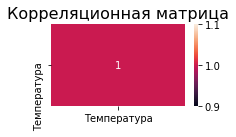

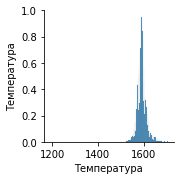

In [10]:
data_info(df_temp)

In [11]:
# Количество замеров температуры для каждой партии
df_temp['key'].value_counts().sort_values()

279      1
195      1
1836     2
273      2
1801     2
        ..
1689    15
44      16
1513    16
1214    16
46      16
Name: key, Length: 3216, dtype: int64

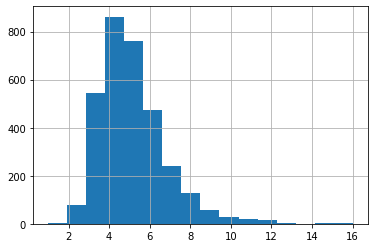

In [12]:
# Количество замеров температуры для каждой партии
df_temp['key'].value_counts().sort_values().hist(bins=16);

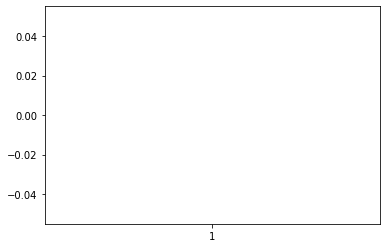

In [13]:
plt.boxplot(df_temp['Температура']);

<AxesSubplot:>

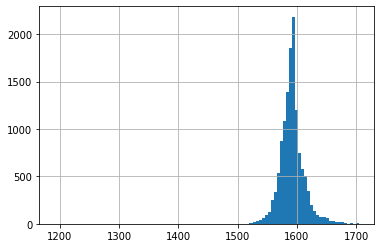

In [14]:
df_temp['Температура'].hist(bins=100)

**Вывод**
1. Есть пропуски в данных о температуре. От замеров без температуры надо будет избавлятся.
2. Дубликаты отсутствуют.
3. Количество замеров температуры для каждой партии, лежит в диапозоне от 1 до 16, медианное значение = 4. 
4. Для партий, в которых количество замеров температуры равно одному построить прогноз будет не возможно, так как целевым признаком является последний замер, а начального замера у нас не будет.
5. Температура сплава лежит в диапозоне от 1191 до 1705. Температура плавления стали равна примерно 1370, поэтому необходимо уточнить у технологов, партии сплава с температурой меньше температуры плавления это брак или какой-то особый сплав?

### Анализ данных о продувке сплава газом

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Количество дубликатов = 0
Количество уникальных партий = 3239


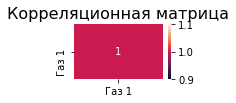

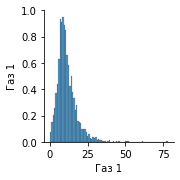

In [15]:
data_info(df_gas)

**Вывод**
1. Пропусков и дубликатов в данных о продувке сплава газом нет.
2. Исходя из анализа данной таблицы, продувка каждой партии сплава газом осуществляется один раз.
3. Объём газа для продувания сплава лежит в диапозоне от 0.008 до 78 с медианным значением 11.

### Анализ данных о подаче сыпучих материалов 

Данные о подаче сыпучиз материалов в сплав содержатся в двух таблицах:
- Данные об оъёме;
- Данные о времени.

Проанализируем обе эти таблицы.
#### Объём

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Количество дубликатов = 0
Количество уникальных партий = 3129


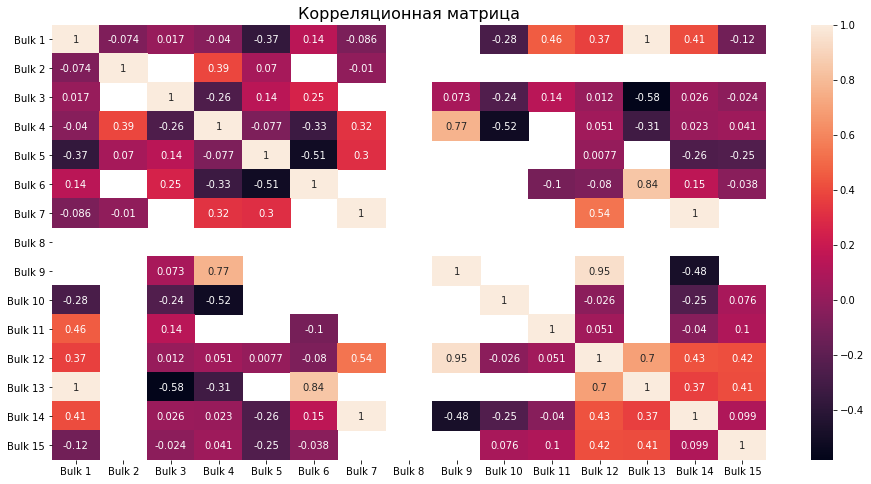

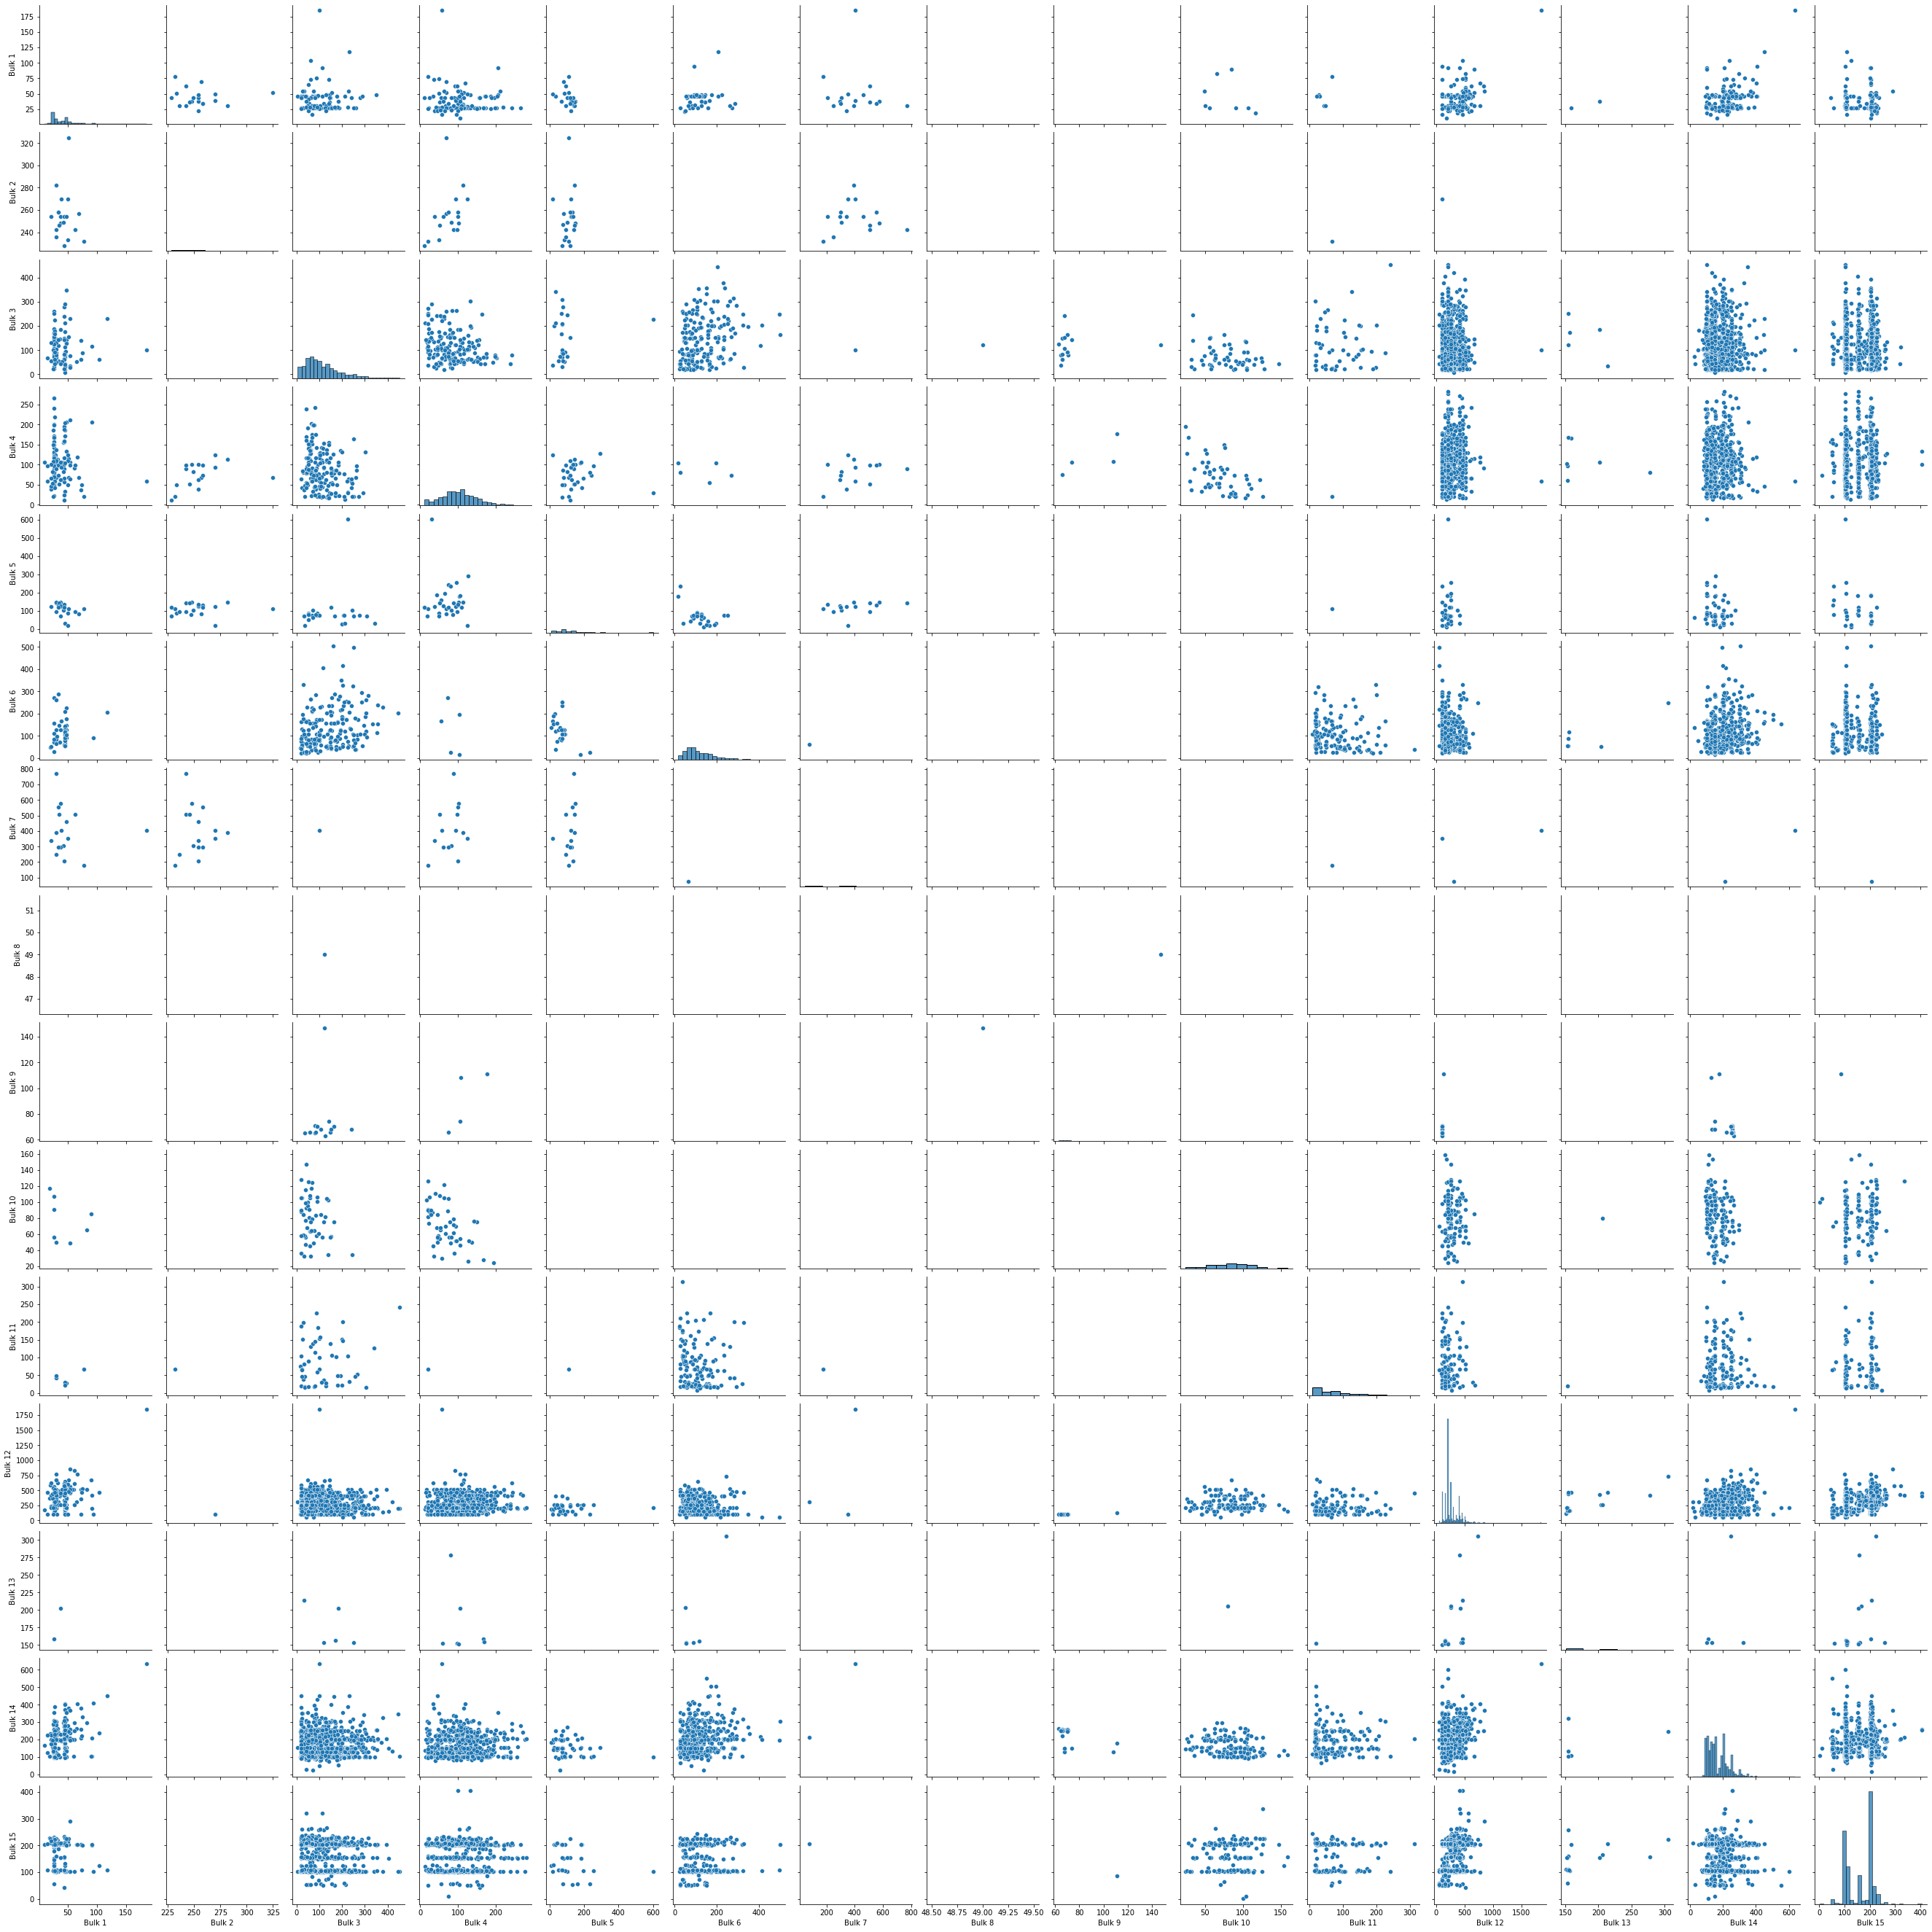

In [16]:
data_info(df_bulk)

In [17]:
# Среднее количество сыпучих добавок для каждой партии
df_bulk.drop('key', axis=1).notna().sum().sum() / df_bulk.shape[0]

3.5663151166506872

**Вывод:**
1. Пропуски в данной таблице означают то, что данные сыпучий материал не подавался в партию сплава. Поэтому пропуски целесообразно будет заполнить нулями.
2. Дубликатов в данных нет.
3. Также можно отметить, что добавка `Bulk 1` всегда добавляется с `Bulk 13` а добавка `Bulk 7` всегда добавляется с `Bulk 14`. (По крайней мере в рамках представленного набора данных)
4. В среднем, в каждую партию сплава добавляется 3 - 4 сыпучие добавки.

#### Время

In [18]:
data_info(df_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Количество дубликатов = 0
Количество уникальных партий = 3129



<Figure size 1152x576 with 0 Axes>

**Вывод:**
1. Аналогично таблице с объёмом сыпучих добавок, пропуски в данной таблице означают то, что данные сыпучий материал не подавался в партию сплава.
2. Дубликатов в данных нет.

**Вывод*

Исходя из анализа обеих таблиц о подаче в сплав сыпучих материалов, можно сделать следующие выводы:
1. Дубликатов не выявлено.
2. Пропуски в обеих таблицах говорят об отсутствии подачи данного материала в сплав.
3. Также можно отметить, что добавка `Bulk 1` всегда добавляется с `Bulk 13` а добавка `Bulk 7` всегда добавляется с `Bulk 14`. (По крайней мере в рамках представленного набора данных)
4. В среднем, в каждую партию сплава добавляется 4-5 порций сыпучих добавок.


### Анализ данных о проволочных материалах 
Данные о подаче проволочных материалов в сплав содержатся в двух таблицах:
- Данные об оъёме;
- Данные о времени.

Проанализируем обе эти таблицы.
#### Объём

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Количество дубликатов = 0
Количество уникальных партий = 3081


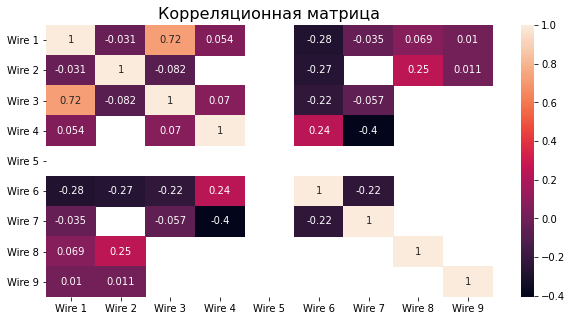

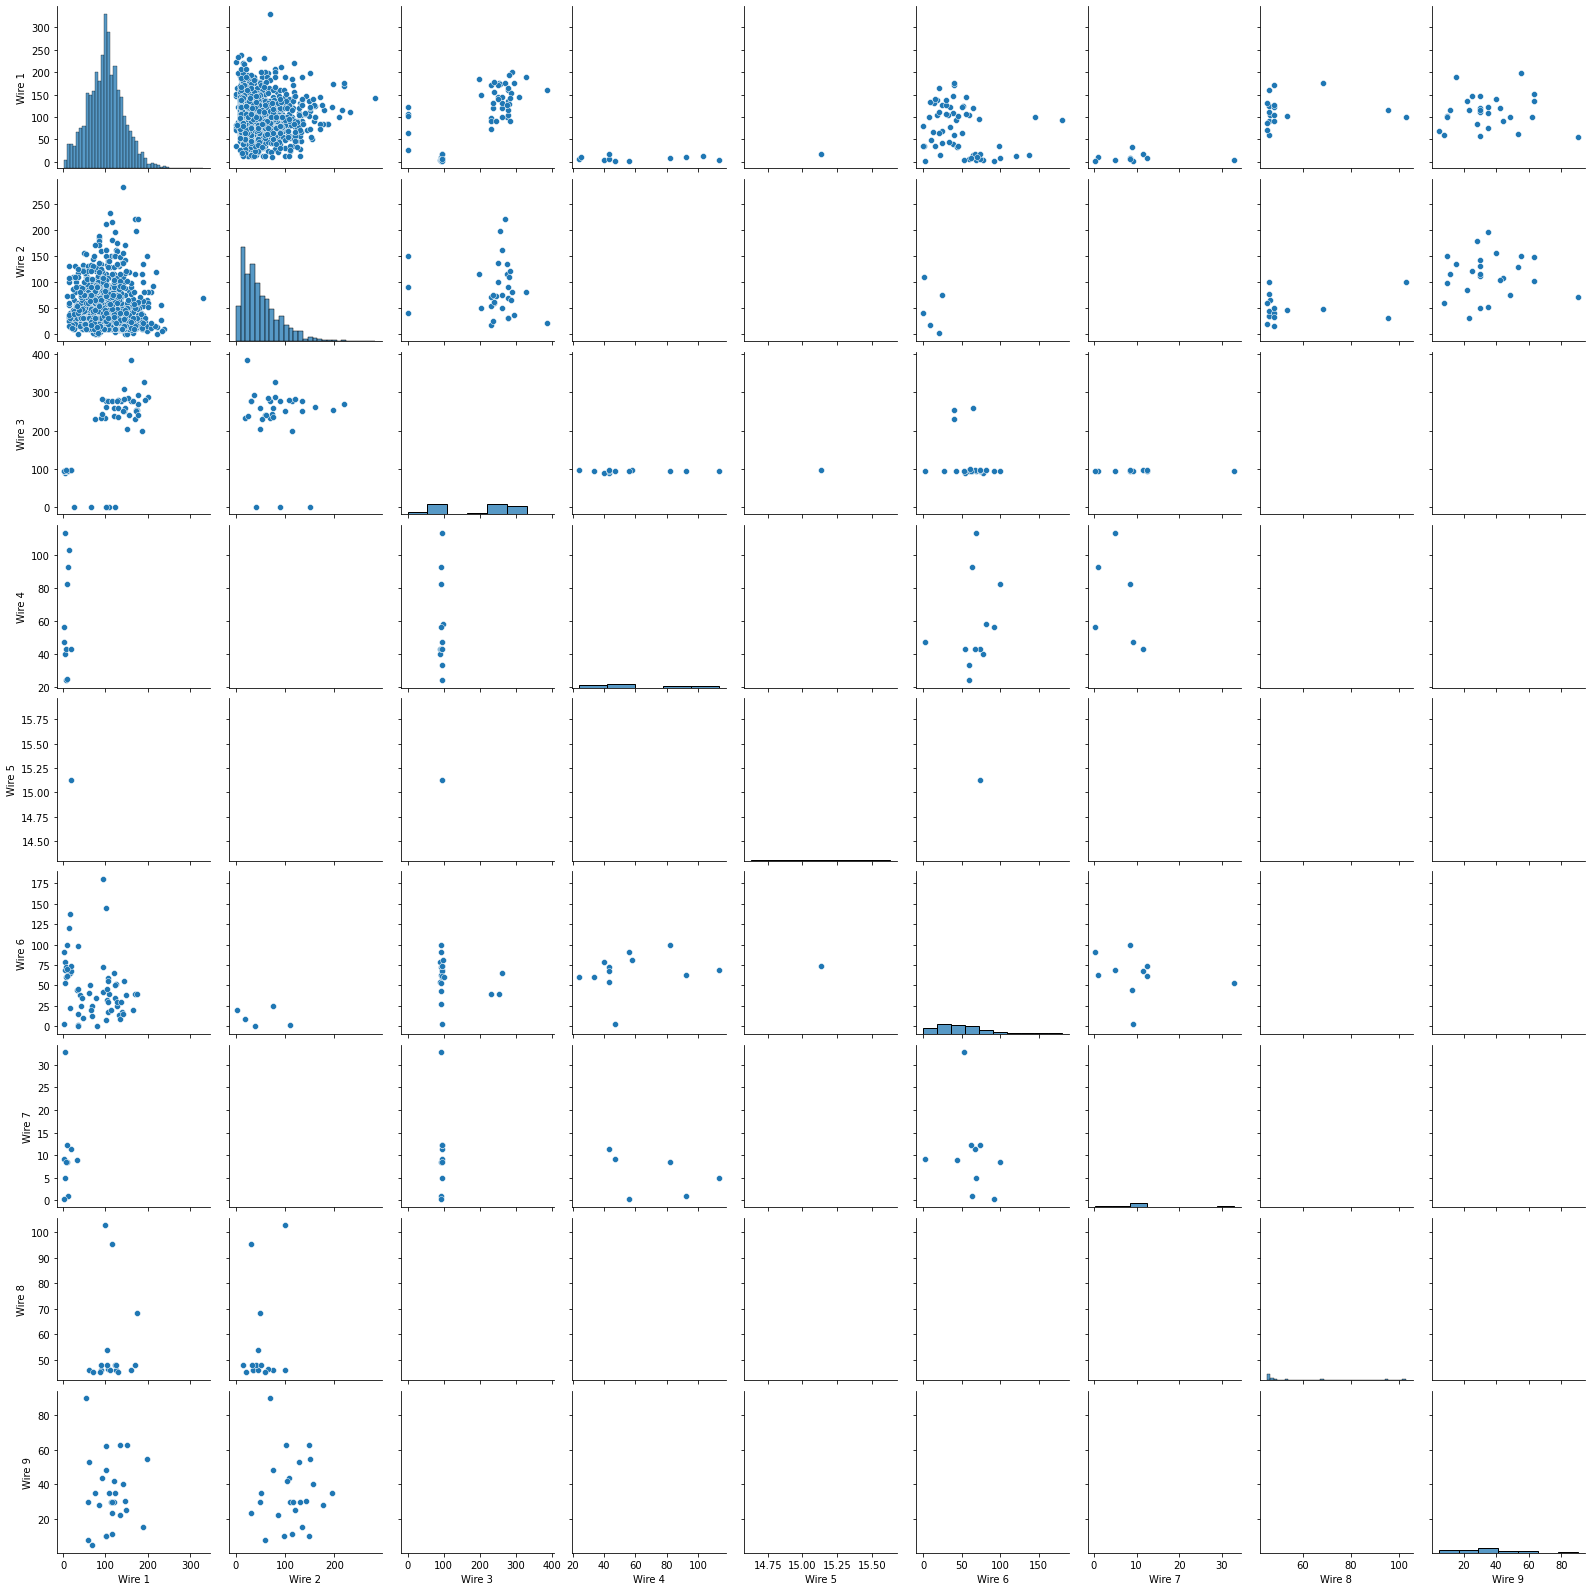

In [19]:
data_info(df_wire)

In [20]:
# Среднее количество проволочных добавок для каждой партии
df_wire.drop('key', axis=1).notna().sum().sum() / df_wire.shape[0]

1.4099318403115872

**Вывод:**
1. Пропуски в данной таблице означают то, что данные материалы не подавались в партию сплава. Поэтому пропуски целесообразно будет заполнить нулями.
2. Дубликатов в данных нет.
3. В каждую партию сплава добавляется, как правило, 1 - 2 проволочных добавок.
4. Добавка Wire 5 добавлялась только в одну партию, добавки Wire 4, Wire 7 и Wire 8 добавлялись в менее чем 20 партий.

#### Время

In [21]:
data_info(df_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Количество дубликатов = 0
Количество уникальных партий = 3081



<Figure size 720x360 with 0 Axes>

**Вывод:**

1. Аналогично таблице с объёмом проволочных добавок, пропуски в данной таблице означают то, что данные сыпучий материал не подавался в партию сплава.
2. Дубликатов в данных нет.

**Вывод**
1. Пропуски в рассмотренных таблицах будет целесообразно заменить на нули.
2. Дубликатов в данных нет.
3. В каждую партию сплава добавляется, как правило, 7 проволочных добавок.
4. Добавка Wire 5 добавлялась только в одну партию, добавки Wire 4, Wire 7 и Wire 8 добавлялись в менее чем 20 партий. В процессе построения модели нужно будет оценить, стоит ли данные признаки удалить из обучающей выборки.

**Вывод по разделу**

1. Данные загружены. На этапе загрузки преобразовали колонки содержащие данные о дате и времени в тип данных `datetime`.
2. Дубликатов во всех таблицах нет.
3. Пропуски:
    - в таблицах о подаче сыпучих и проволочных материалов означают, что данный материал в партию сплава не подпвался. Такие пропуски будем заполнять нулями.
    - в таблице данных о замерах температуры надо будет избавлятся.
4. Рассчитали и создали признаки:
    - Из данных о времени начала и конца нагрева признак `Время нагрева`.
    - Из активной и реактивной мощьности признак `Полная мощьность`.
    - Из значений полной мощьности и времени нагрева признак `Энергия нагрева`.
5. Сильная корреляция между признаками всеми признаками в таблице с даннными о нагреве сплава. Думаю, наиболее целесообразно, для обучения модели использовать значения энергии нагрева, так как в ней уже содержатся сведенья о времени нагрева, активной и реактивной мощьности. Таким образом мы не допустим мультиколлениарности признаков и учтём все факторы из данной таблицы.
6. Значение реактивной мощьности = -715.504924 является выбросом - от него надо будет избавиться.
7. Во всех таблицах разное количество уникальных партий. На этапе формирования признаков для обучения моделей, необходимо будет привести данные к единой размерности.

## Подготовка данных
Подготовку данных будем пролизводить в следующей последовательности:
1. Обработка пропусков, очистка данных от недостоверных сведений;
2. Формирование таблицы признаков на основе имеемых семи таблиц с данными;
3. Формирование выборок.

### Обработка пропусков, очистка данных от недостоверных сведений

Необходимо обработать пропуски:
1. В таблице с данными о замерах температуры:
    - удалим строки с замерами, где нет значений температуры;
    - удалим строки с одним замером температуры;
    - удалим партии со слишком низкой температурой.
2. В таблице с данными о добавлении сыпучих материалов заполним пропуски нулями;
3. В таблице с данными о добавлении проволочных материалов так-же заполним пропуски нулями.
4. Из таблицы о нагреве сплава удалим данные о партии в которой присутствует выброс по реактивной мощьности.

In [22]:
# Удаляем пропуски в данных о замерах температуры
df_temp = df_temp.dropna()
# Проверяем на наличие пропусков
df_temp.isna().sum().sum()


0

In [23]:
# Заполняем пропуски в данных о добавлении сыпучих материалов
df_bulk = df_bulk.fillna(0)
# Проверяем на наличие пропусков
df_bulk.isna().sum().sum()

0

In [24]:
# Заполняем пропуски в данных о добавлении проволочных материалов
df_wire = df_wire.fillna(0)
# Проверяем на наличие пропусков
df_wire.isna().sum().sum()

0

In [25]:
# Удаляем партии сплава в которых только один замер температуры
# формируем список партий с количеством заберов более 1
keys_temp = df_temp['key'].value_counts()
keys_one_temp = [i for i in keys_temp.index if keys_temp[i] == 1]
# Оставляем в таблице только данные с номером партии из списка
df_temp = df_temp.query('key not in @keys_one_temp')

In [26]:
# Удаляем партии сплава в которых температура аномально низкая
# формируем список партий в которых хотябы один замер температуры < 1400
keys_bad_temp = df_temp[df_temp['Температура'] < 1400]['key'].values
# Оставляем в таблице только данные без выброса
df_temp = df_temp.query('key not in @keys_bad_temp')

In [27]:
# Удаляем партии сплава в которых выброс по реактивной мощности
# выясняем номер партии с выбрасом
keys_bad_power = df_arc[df_arc['Реактивная мощность'] < -700]['key'].values[0]
# Оставляем в таблице только данные без выброса
# df_arc = df_arc.query('key != @keys_bad_power')
df_arc = df_arc[df_arc['key'] != keys_bad_power]

**Вывод**

1. Пропуски обработаны.
2. Лишние данные удалены.

### Формирование таблицы признаков на основе имеемых семи таблиц с данными

Для формирования итового набра данных выполним следующие действия:
1. Начнём с таблицы замера температуры:
    - Так как мы будем использовать в качестве признака первый замер, а в качестве целевого признака последний, оставим в таблице только их;
    - В качестве признака нам понадобится и общее время нахождения партии сплава в ковше. Вычислим его как разницу между временем последнего замера температуры и первого.
2. Таблицы с данными о нагреве сплава:
    - Вычислим суммарную энергию нагрева для каждой партии;
    - Присоединим полученные данные к итоговой таблице.
3. Из остальных таблиц добавим данные о количестве добавленных материалов и объёме газа.
4. Сгенерируем и добавим некоторые признаки.
5. Проанализируем полученную таблицу признаков.

#### Данные из таблицы замера температуры

In [28]:
# Агрегируем время начала и время окончания нахождения партии сплава в ковше
df = df_temp.pivot_table(index='key', values=['Время замера'], aggfunc=[min, max])
# Переименовываем колонки
df.columns = ['start_time', 'fin_time']
# Проверяем результат
df.head()

,start_time,fin_time
key,,
1,2019-05-03 11:16:18,2019-05-03 11:30:39
2,2019-05-03 11:37:27,2019-05-03 11:59:12
3,2019-05-03 12:13:17,2019-05-03 12:34:57
4,2019-05-03 12:52:57,2019-05-03 12:59:25
5,2019-05-03 13:23:19,2019-05-03 13:36:01


In [29]:
# Присоединяем данные о начальной температуре
df = df.merge(df_temp, left_on='start_time',right_on='Время замера')
# Удаляем лишние колонки
df = df.drop(['key', 'Время замера'], axis=1)
# Переименовываем колонку
df = df.rename(columns = {'Температура': 'start_temp'})
# Проверяем результат
df.head()

,start_time,fin_time,start_temp
0,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0
1,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0
2,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0
3,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0
4,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0


In [30]:
# Присоединяем данные о финальной температуре
df = df.merge(df_temp, left_on='fin_time',right_on='Время замера')
# Удаляем лишние колонки
df = df.drop('Время замера', axis=1)
# Переименовываем колонку
df = df.rename(columns = {'Температура': 'fin_temp'})
# Проверяем результат
df.head()

,start_time,fin_time,start_temp,key,fin_temp
0,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1,1613.0
1,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,2,1602.0
2,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,3,1599.0
3,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,4,1625.0
4,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,5,1602.0


In [31]:
# Считаем время приготовления партии сплава
df['total_time'] = (df['fin_time'] - df['start_time']).astype('int64') / 1000000000
# Больше нам астрономическое время начали и окончания приготовления не понадобится. Удалим.
df = df.drop(['start_time', 'fin_time'], axis=1)
# Проверяем результат
df.head()

,start_temp,key,fin_temp,total_time
0,1571.0,1,1613.0,861.0
1,1581.0,2,1602.0,1305.0
2,1596.0,3,1599.0,1300.0
3,1601.0,4,1625.0,388.0
4,1576.0,5,1602.0,762.0


**Вывод:** Начало положено. Таблица признаков содержит нужные нам данные.

#### Данные из таблицы о нагреве сплава:

In [32]:
# Вычислим суммарную энергию и время нагрева сплава для каждой партии
energy = df_arc[['key', 'Энергия нагрева', 'Время нагрева']].groupby('key').sum()
# Присоединяем данные о финальной температуре
df = df.merge(energy, on='key')
# Переименовываем колонки
df = df.rename(columns = {'Энергия нагрева': 'total_energy',
                          'Время нагрева': 'heating_time'
                         })
# Проверяем результат
df.head()

,start_temp,key,fin_temp,total_time,total_energy,heating_time
0,1571.0,1,1613.0,861.0,1442.377754,1098.0
1,1581.0,2,1602.0,1305.0,881.233565,811.0
2,1596.0,3,1599.0,1300.0,525.066777,655.0
3,1601.0,4,1625.0,388.0,796.911309,741.0
4,1576.0,5,1602.0,762.0,1199.137958,869.0


**Вывод:** Данные о энегрии нагрева добавлены.

#### Данные из таблиц о количестве добавленных материалов и объёме газа.

In [33]:
# Присоединяем данные о продувке сплава газом
df = df.merge(df_gas, on='key')
# Переименовываем колонку
df = df.rename(columns = {'Газ 1': 'gas'})
# Проверяем результат
df.head()

,start_temp,key,fin_temp,total_time,total_energy,heating_time,gas
0,1571.0,1,1613.0,861.0,1442.377754,1098.0,29.749986
1,1581.0,2,1602.0,1305.0,881.233565,811.0,12.555561
2,1596.0,3,1599.0,1300.0,525.066777,655.0,28.554793
3,1601.0,4,1625.0,388.0,796.911309,741.0,18.841219
4,1576.0,5,1602.0,762.0,1199.137958,869.0,5.413692


In [34]:
# Присоединяем данные о сыпучих добавках
# df_bulk['total_bulk'] = df_bulk[bulks].apply(sum, axis=1)
df = df.merge(df_bulk, on='key')
# Проверяем результат
df.head()

,start_temp,key,fin_temp,total_time,total_energy,heating_time,gas,Bulk 1,Bulk 2,Bulk 3,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1571.0,1,1613.0,861.0,1442.377754,1098.0,29.749986,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,1581.0,2,1602.0,1305.0,881.233565,811.0,12.555561,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,1596.0,3,1599.0,1300.0,525.066777,655.0,28.554793,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,1601.0,4,1625.0,388.0,796.911309,741.0,18.841219,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,1576.0,5,1602.0,762.0,1199.137958,869.0,5.413692,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [35]:
# Присоединяем данные о проволочных добавках
# df_wire['total_wire'] = df_wire[wires].apply(sum, axis=1)
df = df.merge(df_wire, on='key')
# Проверяем результат
df.head()

,start_temp,key,fin_temp,total_time,total_energy,heating_time,gas,Bulk 1,Bulk 2,Bulk 3,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1571.0,1,1613.0,861.0,1442.377754,1098.0,29.749986,0.0,0.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1581.0,2,1602.0,1305.0,881.233565,811.0,12.555561,0.0,0.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,3,1599.0,1300.0,525.066777,655.0,28.554793,0.0,0.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1601.0,4,1625.0,388.0,796.911309,741.0,18.841219,0.0,0.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1576.0,5,1602.0,762.0,1199.137958,869.0,5.413692,0.0,0.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Вывод:** Данные о добавлении материалов и продувки газом добавлены. 

#### Добавление сгенерированных признаков

Думаю, будет полезно добавить следующие признаки:
1. Признак, характеризующий, сколько энергии нагрева потратили за секунду общего времени приготовления сплава;
2. Признак характеризующий время охлаждения сплава;
3. Признак характеризующий отношение времени нагрева к общему времени приготовления сплава.

In [36]:
# добавляем признак сколько энергии нагрева потратили за секунду общего времени приготовления сплава
df['energy_per_second'] = df['total_energy'] / df['total_time']
# Признак время охлаждения сплава
df['cool_time'] = df['total_time'] - df['heating_time']
# Признак отношение времени нагрева к общему времени приготовления сплава
df['scaller_time'] = df['heating_time'] / df['total_time']

**Вывод:** Признаки сформированны и добавлены в итоговый набор данных. 

#### Анализ признаков

Проанализируем полученную итоговую таблицу признаков:
- Построим корреляционную матрицу;
- Построим парные графики.

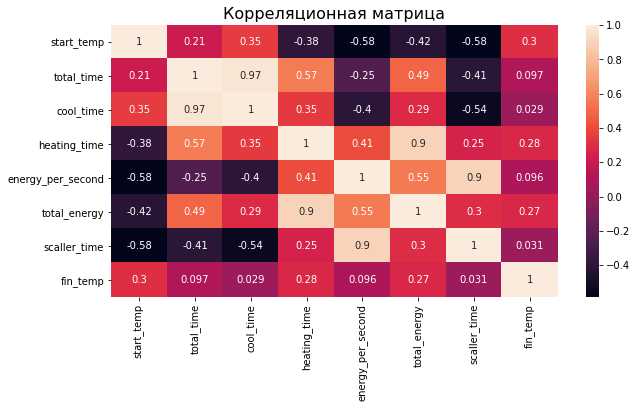

In [37]:
# Построение корреляционной матрицы
plt.figure(figsize=(10,5))
corr_matrix = sns.heatmap(df[['start_temp', 
                 'total_time', 
                 'cool_time',
                 'heating_time', 
                 'energy_per_second', 
                 'total_energy', 
                 'scaller_time', 
                 'fin_temp'
                ]].corr(),annot=True)
corr_matrix.axes.set_title("Корреляционная матрица", fontsize=16)
plt.show()

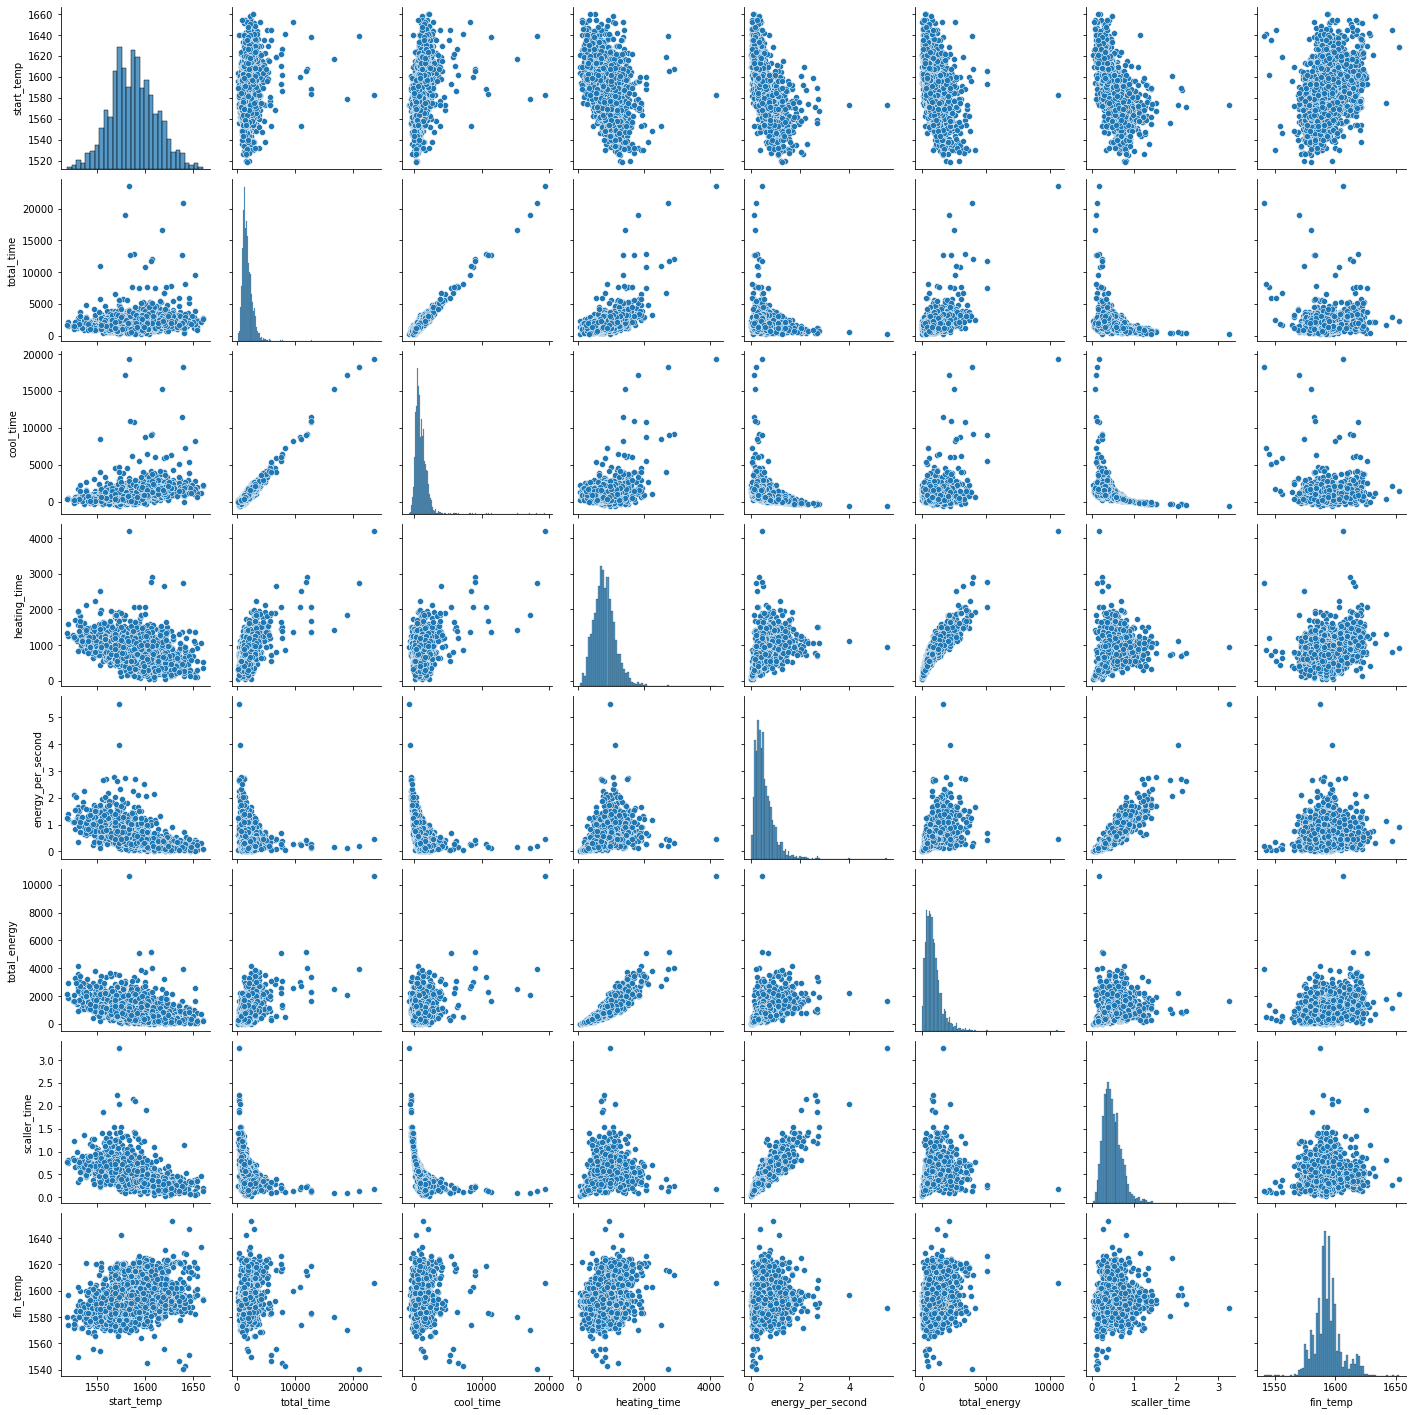

In [38]:
# Построение парных графиков
sns.pairplot(df[['start_temp', 
                 'total_time', 
                 'cool_time',
                 'heating_time', 
                 'energy_per_second', 
                 'total_energy', 
                 'scaller_time', 
                 'fin_temp'
                ]]);

**Вывод:** Анализ признаков показал:
- признаки `total_time` и `cool_time` имеют сильную корреляцию - оставим для обучения только одно из них;
- признаки `total_energy` и `heating_time`. Время нагрева входит в формулу расчёта энергии, и использовать его в модели не планировалось;
- `energy_per_second` и `scaller_time` также сильно коррелируют. В модель подадим только `scaller_time`.

In [39]:
df.head()

,start_temp,key,fin_temp,total_time,total_energy,heating_time,gas,Bulk 1,Bulk 2,Bulk 3,...,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,energy_per_second,cool_time,scaller_time
0,1571.0,1,1613.0,861.0,1442.377754,1098.0,29.749986,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.675235,-237.0,1.275261
1,1581.0,2,1602.0,1305.0,881.233565,811.0,12.555561,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.675275,494.0,0.621456
2,1596.0,3,1599.0,1300.0,525.066777,655.0,28.554793,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.403898,645.0,0.503846
3,1601.0,4,1625.0,388.0,796.911309,741.0,18.841219,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.053895,-353.0,1.909794
4,1576.0,5,1602.0,762.0,1199.137958,869.0,5.413692,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.573672,-107.0,1.140420


In [40]:
# Проверим что получилось
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   start_temp         2324 non-null   float64
 1   key                2324 non-null   int64  
 2   fin_temp           2324 non-null   float64
 3   total_time         2324 non-null   float64
 4   total_energy       2324 non-null   float64
 5   heating_time       2324 non-null   float64
 6   gas                2324 non-null   float64
 7   Bulk 1             2324 non-null   float64
 8   Bulk 2             2324 non-null   float64
 9   Bulk 3             2324 non-null   float64
 10  Bulk 4             2324 non-null   float64
 11  Bulk 5             2324 non-null   float64
 12  Bulk 6             2324 non-null   float64
 13  Bulk 7             2324 non-null   float64
 14  Bulk 8             2324 non-null   float64
 15  Bulk 9             2324 non-null   float64
 16  Bulk 10            2324 

**Вывод**

Таблица признаков сформирована. После всех преобразований, у нас осталось не так много данных: всего 2324 строки.

### Формирование выборок

С учётом того, что строк в итоговой таблице с признаками осталось давольно не большое количество, делить полученный набор данных будем на две выборки: тренировачную и тестовую. Проверку работы модели на этапе тренировки модели и подбора гиперпараметров, будем осуществлять способом перекрёстной валидации.

In [41]:
# Определяем признаки
features = df.drop(['key', 'fin_temp', 'heating_time', 'total_time', 'energy_per_second'], axis=1)
# Определяем целевой признак
target  = df['fin_temp']
# Делим набор данных на выборки
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.3, 
                                                                            random_state=SEED)

# проверим размеры выборок
pd.DataFrame(data=[features_train.shape[0], target_train.shape[0],
                   features_test.shape[0],  target_test.shape[0]],
             index=['features_train', 'target_train', 
                    'features_test',  'target_test'],
             columns=['Размер выборки']
            )

,Размер выборки
features_train,1626
target_train,1626
features_test,698
target_test,698


**Вывод** 

Признаки и целевой признак выделены из итоговой таблицы с данными. Сформированы тренировочная и тестовая выборки.

**Вывод по разделу**

Задачи данного раздела выполнены. Было произведено:
1. Устранение проблемных вопросов с данными;
2. Формирование итоговой таблицы данных;
3. Формирование выборок.

Данные готовы к обучению моделей.

## Построение модели машинного обучения

Построим несколько моделей машинного обучения:
1. Линейная регрессия;
2. Дерево решений;
3. Случайный лес;
4. CatBoostRegressor.

В конце выберем модель показывающую наилучшее качество.

### Линейная регрессия

Так как линекйные модели чувствительны к мосштабу признаков, перед обучением применим к набору признаков StandardScaler.

In [42]:
# Мосштабирование признаков перед подачей в линейную модель
sc = StandardScaler()
features_train_sc = sc.fit_transform(features_train)

In [43]:
lr_model = LinearRegression()
cross_val_score(lr_model, features_train_sc, target_train, n_jobs=-1, scoring='neg_mean_absolute_error').mean()

-6.574199931837367

**Вывод** 

Линейная модель показывает хорошее качество.

### Дерево решений

Обучим модель с гиперпараметрами по умолчанию, затем с подбором гиперпараметров по сетке.

In [44]:
# DecisionTreeRegressor с параметрами по умолчанию
tree_model = DecisionTreeRegressor(random_state=SEED)
cross_val_score(tree_model, features_train, target_train, n_jobs=-1,scoring='neg_mean_absolute_error').mean()

-8.248890986314297

In [45]:
%%time
# DecisionTreeRegressor с автоподбором параметров
parametrs = { 'max_depth':range(2,40)}

treeCV = GridSearchCV(tree_model, parametrs, scoring='neg_mean_absolute_error', cv=5, )
treeCV.fit(features_train, target_train)
print('Параметры модели:', treeCV.best_params_)
print('Лучший MAE модели:', treeCV.best_score_)

Параметры модели: {'max_depth': 6}
Лучший MAE модели: -6.992372322753127
CPU times: user 2.56 s, sys: 24 ms, total: 2.58 s
Wall time: 2.6 s


**Вывод** 

Решающее дерево показывает качество хуже линейной модели.

### Случайный лес

Обучим модель с гиперпараметрами по умолчанию, затем с подбором гиперпараметров по сетке.

In [46]:
# RandomForestRegressor с параметрами по умолчанию
rf_model = RandomForestRegressor(random_state=SEED)
cross_val_score(rf_model, features_train, target_train, n_jobs=-1,scoring='neg_mean_absolute_error').mean()

-6.001930212364322

In [47]:
%%time
# RandomForestRegressor с автоподбором параметров
parametrs = { 'n_estimators': range (120, 201, 10),
              'max_depth': range (12, 25, 2)}

rfCV = GridSearchCV(rf_model, parametrs, scoring='neg_mean_absolute_error', cv=5)
rfCV.fit(features_train, target_train)
print('Параметры модели:', rfCV.best_params_)
print('Лучший MAE модели:', rfCV.best_score_)

Параметры модели: {'max_depth': 14, 'n_estimators': 200}
Лучший MAE модели: -5.973106652797432
CPU times: user 5min 58s, sys: 921 ms, total: 5min 59s
Wall time: 6min


**Вывод**

Модель случайного леса показывает лучший результат из всех рассмотренных до текущего момента.

### CatBoostRegressor

Обучим модель с гиперпараметрами по умолчанию, затем с подбором гиперпараметров случайным поиском, с использованием встроенного метода.

In [48]:
# CatBoostRegressor с параметрами по умолчанию
cat_model = CatBoostRegressor(silent=True, random_state=SEED)

cross_val_score(cat_model, features_train, target_train, n_jobs=-1, scoring='neg_mean_absolute_error').mean()

-5.880728741740207

In [49]:
%%time
# CatBoostRegressor с автоподбором параметров
param_grid = {'l2_leaf_reg': range(1,20),
              'learning_rate': [0.005, 0.01, 0.02, 0.05, 0.08, 0.1, 0.2],
              'depth' : range(1,10)
              }

cat_model.randomized_search(param_grid,
            X=features_train,
            y=target_train,
            cv=5,
            partition_random_seed=SEED,
            verbose=False,
            plot=True
            )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 14.38889896
bestIteration = 999


bestTest = 20.4889629
bestIteration = 999


bestTest = 17.96987965
bestIteration = 999


bestTest = 19.85168131
bestIteration = 999


bestTest = 25.16107134
bestIteration = 998


bestTest = 30.15275536
bestIteration = 999


bestTest = 32.55946118
bestIteration = 999


bestTest = 39.00253602
bestIteration = 999


bestTest = 58.14196696
bestIteration = 998


bestTest = 54.55545983
bestIteration = 999

Training on fold [0/5]

bestTest = 14.83979084
bestIteration = 998

Training on fold [1/5]

bestTest = 15.81795715
bestIteration = 999

Training on fold [2/5]

bestTest = 14.07275519
bestIteration = 999

Training on fold [3/5]

bestTest = 11.48762589
bestIteration = 999

Training on fold [4/5]

bestTest = 13.05183187
bestIteration = 999

CPU times: user 48 s, sys: 888 ms, total: 48.9 s
Wall time: 1min 1s


{'params': {'depth': 2, 'l2_leaf_reg': 12, 'learning_rate': 0.01},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
   

In [44]:
# CatBoostRegressor с лучшими гиперпараметрами
cat_model = CatBoostRegressor(l2_leaf_reg=1,
                              learning_rate=0.02,
                              depth=5,
                              silent=True, random_state=SEED)

cross_val_score(cat_model, features_train, target_train, n_jobs=-1, scoring='neg_mean_absolute_error').mean()

-5.75338928371429

**Вывод**

Модель CatBoostRegressor показывает наилучшую метрику качества.

**Вывод по разделу**

В данном разделе выполнили обучение с подбором гиперпараметров нескольких моделей. Лучший результат показывает модель CatBoostRegressor с MAE=5.8. Именно эту модель выберем для рекомендации запуска в производство и будем тестировать в следующем разделе.

## Тестирование модели

1. Протестируем лучшую модель на тестовом наборе данных;
2. Проверим работу модели на адекватность;
3. Оценим важность признаков.

### Тестирование на тестовом наборе данных

In [45]:
best_model = CatBoostRegressor(l2_leaf_reg=1,
                              learning_rate=0.02,
                              depth=5,
                              silent=True, random_state=SEED)
best_model.fit(features_train, target_train)
prdictions = best_model.predict(features_test)
mean_absolute_error(target_test, prdictions)

5.5923581711578185

**Вывод**

На тестовом наборе данных модель показывает метрику немного лучше чем на перекрёстной валидации тренировочных данных. Видимо причина в том, что обучалась она на полном тестовом наборе, а не на частичном, как при кроссвалидации. Метрика качества нас вполне устраевает.

### Проверка модели на адекватность

1. Сравним работу мордели с константной моделью;
2. Сравним работу модели с моделью, выдавающей конечную температуру равную начальной

In [46]:
# Константная модель
dr = DummyRegressor()
dr.fit(features_train, target_train)
prdictions = dr.predict(features_test)
mean_absolute_error(target_test, prdictions)

8.258489375724706

In [47]:
# Модель выдающая за результат начальную температуру

mean_absolute_error(target_test, features_test['start_temp'])

20.121776504297994

**Вывод**

1. Построенная модель работает на 33% лучше константной модели.
2. Предсказывать температуру просто беря начальную температуру - плохая идея.


### Оценка важности признаков

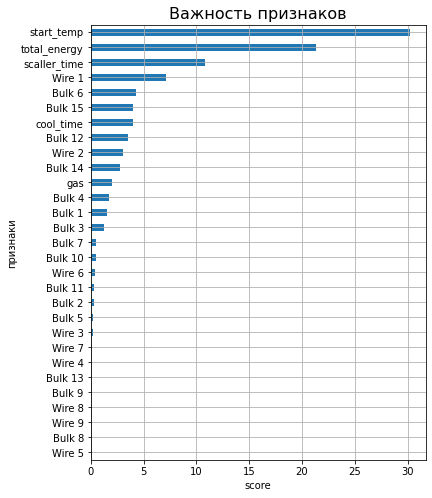

In [52]:
# Выделим признаки
efectiv_score = pd.DataFrame(data={'score': best_model.feature_importances_}, 
                            index=features_train.columns).sort_values(by='score')
# Выведем их на экран
ax = efectiv_score.plot(kind='barh', grid=True, figsize=(6,8), legend=False);
ax.set_title("Важность признаков", fontsize=16)
ax.set_ylabel("признаки")
ax.set_xlabel("score")
plt.show;

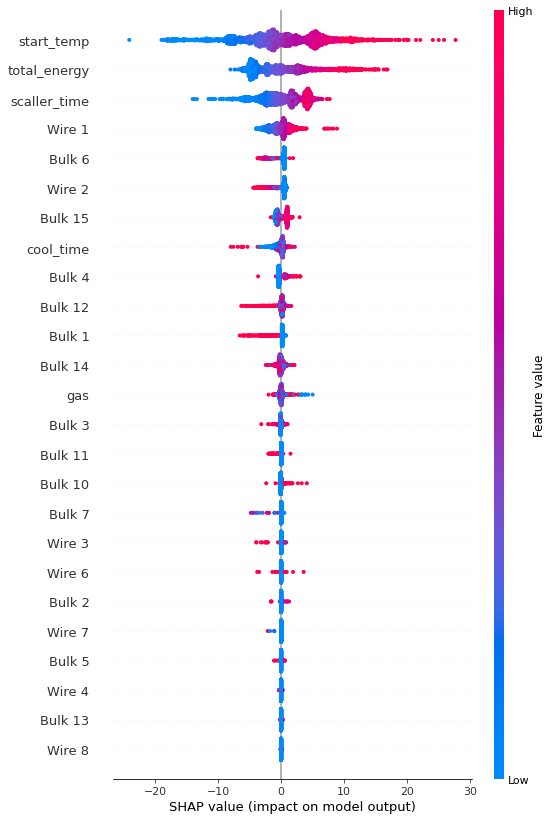

In [60]:
shap_test = shap.TreeExplainer(best_model).shap_values(features_train)
shap.summary_plot(shap_test, features_train, max_display=25, auto_size_plot=True)

**Вывод** 

Анализируя степень важности признаков можно сделать следующие выводы:
1. Самым важным признаком, модель посчитала начальную температуру партии сплава. Это не удивительно, так как от этой температуры мы отталкиваемся при рассчёте конечной температуры.
2. Второй по важности оказалась суммарная энергия нагрева сплава, что тоже вполне логично.
3. Третим признаком по степени важности оказался сгенерированный признак показывающий отношение времени нагрева к общему времени нахождения сплава в ковше.
4. Признаки отражающие количество добавленных материалов и объёма прокаченного газа оказались менее важны.

"В отчёте ответьте на вопросы:<br>

- Какие пункты плана были выполнены, а какие — нет (поясните почему)?<br>
- Какие трудности возникли и как вы их преодолели?<br>
- Какие ключевые шаги в решении задачи выделили?<br>
- Какая ваша итоговая модель и какое у неё качество?<br>

**Вывод по разделу**

В ходе тестирования модели произвели проверку работы модели на тестовых данных, сравнение с фиктивной моделью и оценили важность признаков.

1. Тестирование модели показало, что метрика качества на тестовых данных несколько лучше чем на тренировачной выборки с кроссвалидацией, что вполне закономерно. 
2. Фиктивная модель работает хуже чем созданная, а это значит, что усилия оказались не напрасны. 
3. Оценка важности признаков сюрпризов не преподнесла: 
    - Самые важные признаки - это начальная температура сплава и энергия нагрева. 
    - Следующими по важности оказался сгенерированный признак, показывающий отношение времени нагрева к общему времени приготовления сплава. Это говорит нам о том, что всегда полезно помочь модели увидеть неочевидные для неё закономерности.
    - Признаки характеризующие добавки в сплав оказались не так важны как данные о температуре, нагреве и их производные.

## Вывод

Была поставлена задача создать модель машинного обучения, прогнозирующую температуру сплава перед подачей его на розлив. В нашем распоряжении были таблицы содержащие данные о замерах температуры, о нагреве сплава, о добавках в сплав и о продувке сплава газом.
1. Данные были изучены, очищены от выбросов и недостоверных данных. 
2. Затем из разрозненных таблиц, данные были агрегированны и собраны в единый набор. Также, были рассчитаны и добавлены признаки, которые наиболее полно характеризовали процесс приготовления сплава, и которые помогли модели более качественно строить прогноз. Перед обучением моделей, полный набор данных был разделён на тренировочный и тестовый набор данных. 
3. На тренировачном наборе данных, были обучены несколько моделей с подбором гиперпараметров. Лучшее качество показала модель `CatBoostRegressor`. Она показала MAE=5.8. 
4. При тестировании данная модель также показала хорошее качество MAE=5.5. При сравнении модели с константной моделью, модель доказала свою эффективность - качество созданной модели оказалось на треть выше чем фиктивной модели. Анализ важности признаков показал, что для проноза наиболее важны начальная температура сплава и энергия нагрева. Также хорошую помощь модели в качяественном пргнозировании оказали сгенерированные признаки.

Таким образом, задачу построения модели машинного обучения, прогнозирующую температуру сплава перед подачей его на розлив можно считать выполненной.